# Simple scanning simulations

We want to use this notebook to look at a simple scanning simulation. Let's start by loading up some modules that are needed for the analysis. 

In [1]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
%matplotlib inline

In [2]:
import qpoint as qp
print(qp.__file__)

/Users/jon/.local/lib/python3.7/site-packages/qpoint/__init__.py


Before starting the scanning simulation, we need to invoke some model of the underlying sky. For this example, we describe the sky as statistically isotropic and Gaussian I, Q, and U fields (with underlying power spectra and correlations as determined in the WMAP 7-year release).

In [3]:
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

Here we set parameters that describe the pointing, the instrument and the beams. For this example, we just pick identical symmetric Gaussian beams with no cross-polarization. This will later allow us to easily check whether the code reproduces this known case.

In [22]:
fwhm = 40
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian')

spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=[-10],       # Center of scan
                 dec0=[-57.5],
                 az_throw=50,     # Scan width
                 scan_speed=1)

mlen        = 24 * 60 * 60        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

An seasoned experimentalist might notice that we are defining scan regions and parameters that are not very dissimilar from that of the BICEP class of experiments. These experiments scan around 1-2% of the sky. Now that we have defined some of the boundary conditions of our experiment, we can start initializing scan strategy objects.

In [23]:
b2 = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)

# Create a 3 x 3 square grid of Gaussian beams (f.o.v. is 3 degrees)
b2.create_focal_plane(nrow=3, ncol=3, fov=3, 
                      **beam_opts)

# Calculate tods in two chunks
chunks = b2.partition_mission(0.5*b2.mlen*b2.fsamp) 

# Allocate and assign parameters for mapmaking
b2.allocate_maps(nside=256)

# Set instrument rotation
b2.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])

# Set elevation stepping
b2.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])

# Set HWP modulation
b2.set_hwp_mod(mode='continuous', freq=1.)

In [24]:
# Generate timestreams, bin them and store as attributes
b2.scan_instrument_mpi(alm, **scan_opts)
# Solve for the maps
maps, cond = b2.solve_for_map()

Scanning with 18 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
[rank 000]: working on: r001c000A, r001c000B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
[rank 000]: working on: r002c000A, r002c000B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
[rank 000]: working on: r000c001A, r000c001B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
[rank 000]: working on: r001c001A, r001c001B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
[rank 000]: working on: r002c001A, r002c001B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
[rank 000]: working on: r000c002A, r000c002B
[rank 000]

# Results

With the data generated and binned into maps, we can visualize the results. We plot the condition number map and the solved I, Q and U maps. We expect the condition number to be as low as possible (=2) for almost all pixels because of the continuous HWP rotation and the instrument rotation.

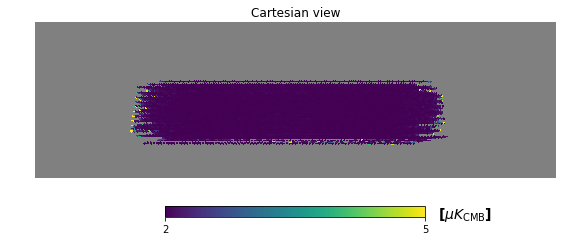

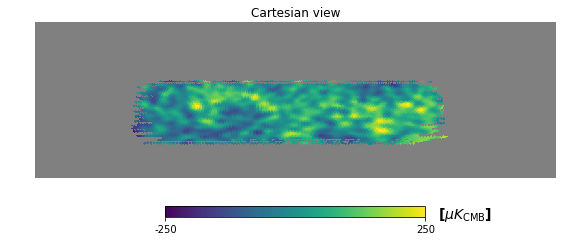

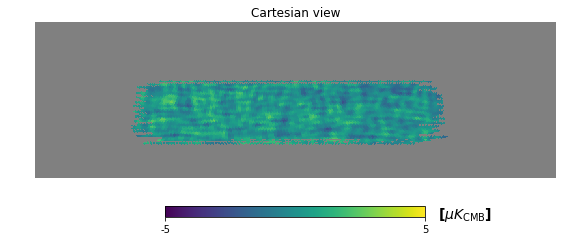

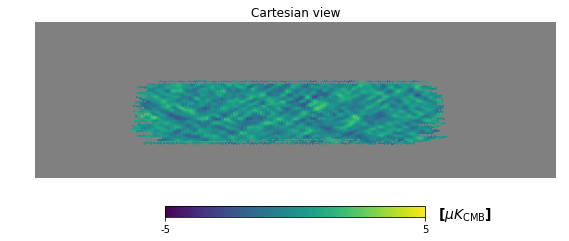

In [21]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]', lonra=[-60, 40], latra=[-70, -40])
hp.cartview(cond, min=2, max=5, **cart_opts)
hp.cartview(maps[0], min=-250, max=250, **cart_opts)
hp.cartview(maps[1], min=-5, max=5, **cart_opts)
hp.cartview(maps[2], min=-5, max=5, **cart_opts)

Finally, we can check the results by comparing them to the smoothed input map (remember, this is why we picked identical symmetric Gaussian beams) by plotting difference maps.

In [14]:
hp.smoothalm(alm, fwhm=np.radians(fwhm / 60.))
sm_in = hp.alm2map(alm, hp.get_nside(maps[0]))
diff = maps - sm_in

Sigma is 16.986436 arcmin (0.004941 rad) 
-> fwhm is 40.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


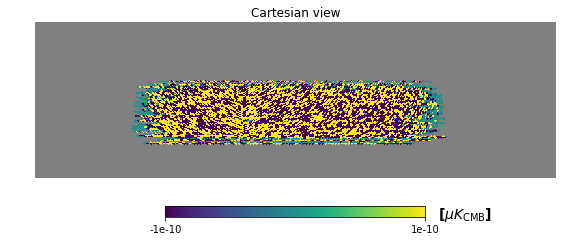

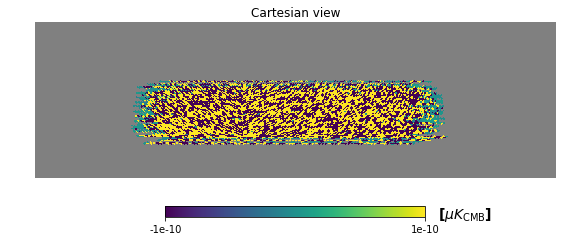

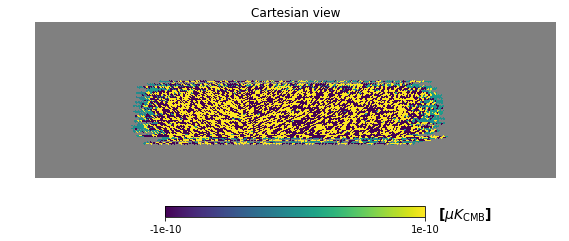

In [15]:
hp.cartview(diff[0], min=-1e-10, max=1e-10, **cart_opts)
hp.cartview(diff[1], min=-1e-10, max=1e-10, **cart_opts)
hp.cartview(diff[2], min=-1e-10, max=1e-10, **cart_opts)

So, up to some Q <-> U leakage at the 1e-10 uK level, we reproduce the expected result.